In [13]:
!pip install pmdarima

In [9]:
conda install -c conda-forge fbprophet

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed

Note: you may need to restart the kernel to use updated packages.



Examining @/win-64::__win==0=0:  75%|#######5  | 3/4 [00:05<00:02,  2.19s/it]          
                                                                             

Examining conflict for python fbprophet:   0%|          | 0/4 [00:00<?, ?it/s]
                                                                              

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - fbprophet -> python[version='2.7.*|3.5.*|3.6.*|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|>=3.8,<3.9.0a0|>=3.7,<3.8.0a0']

Your python: python=3.9

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.





In [30]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sn
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
import warnings
warnings.filterwarnings('ignore')
#import fbprophet
import pmdarima as pm
% matplotlib inline


UsageError: Line magic function `%` not found.


In [31]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
play=pd.DataFrame([[x for x in range(1,11)],[x**2 for x in range(1,11)]]).T
play.columns=['original','sqared']
play

,original,sqared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


In [33]:
play.original.diff()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

Text(0.5, 1.0, 'Second diff')

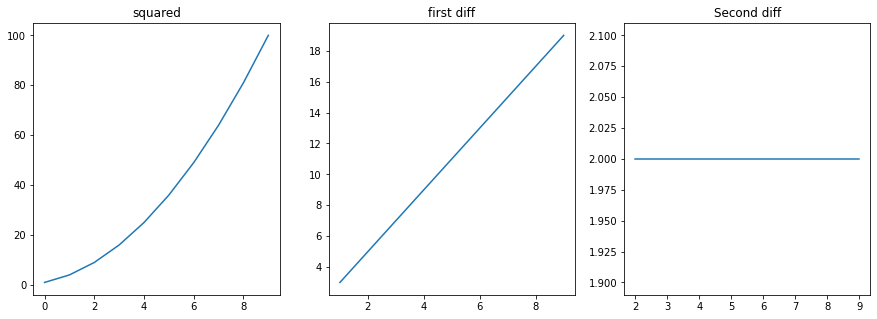

In [34]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].plot(play.sqared)
ax[0].set_title('squared')
ax[1].plot(play.sqared.diff())
ax[1].set_title('first diff')
ax[2].plot(play.sqared.diff().diff())
ax[2].set_title('Second diff')

In [35]:
np.log(play.sqared)

0    0.000000
1    1.386294
2    2.197225
3    2.772589
4    3.218876
5    3.583519
6    3.891820
7    4.158883
8    4.394449
9    4.605170
Name: sqared, dtype: float64

Text(0.5, 1.0, 'log')

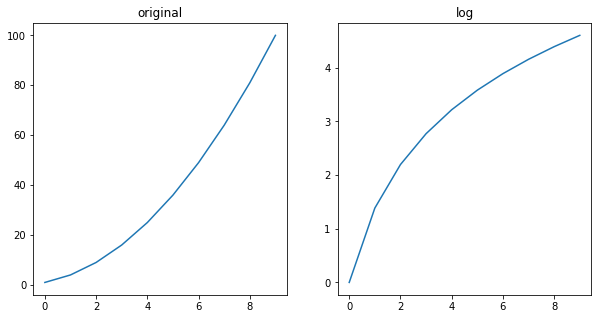

In [36]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(play.sqared)
ax[0].set_title('original')
ax[1].plot(np.log(play.sqared))
ax[1].set_title('log')

In [37]:
#data pred and eda
monthly_temp=pd.read_csv('./mean-monthly-temperature-1907-19.csv',skipfooter=2,infer_datetime_format=True,header=0,index_col=0,engine='python',names=['month','temp'])
monthly_temp.index=pd.to_datetime(monthly_temp.index)

In [38]:
monthly_temp

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8
...,...
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7


In [39]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


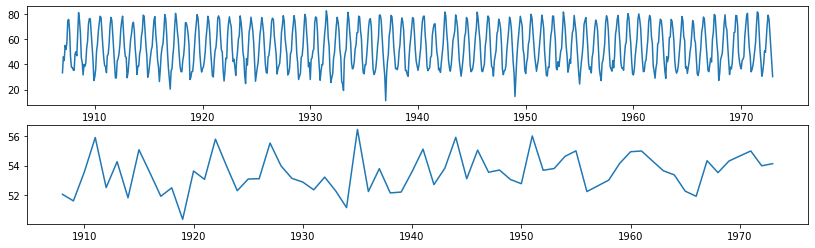

In [40]:
plt.rcParams['figure.figsize']=[14,4]
annual_temp=monthly_temp.resample('A').mean()
fig,ax=plt.subplots(2,1)
ax[0].plot(monthly_temp)
ax[1].plot(annual_temp)

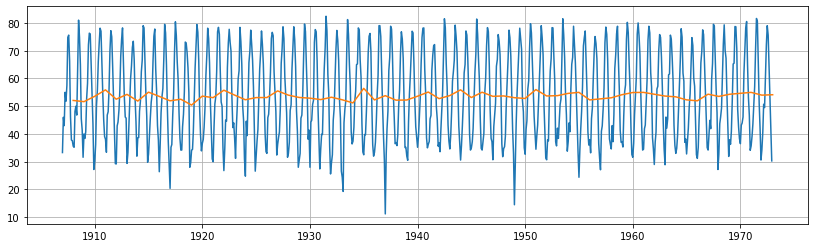

In [41]:
plt.plot(monthly_temp)
plt.plot(annual_temp)
plt.grid(b=True)

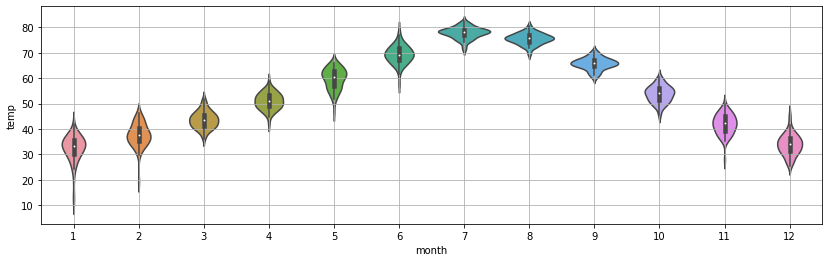

In [42]:
sns.violinplot(x=monthly_temp.index.month,y=monthly_temp.temp)
plt.grid(b=True)

In [43]:
chunks=np.split(monthly_temp.temp,indices_or_sections=12)

In [44]:
mean_vals=np.mean(chunks,axis=1)
var_vals=np.var(chunks,axis=1)
vals={'mean_vals':mean_vals,'var_vals':var_vals}
mean_var=pd.DataFrame(vals)
mean_var

,mean_vals,var_vals
0,52.674242,225.907973
1,53.654545,246.031570
2,52.837879,247.400838
3,54.078788,250.787429
4,52.439394,277.865721
5,53.457576,283.619412
6,53.718182,224.882397
7,54.422727,265.442059
8,53.457576,238.561230
9,54.425758,257.425852


In [45]:
#define Dickey-Fuller Test function
from statsmodels.tsa.stattools import adfuller

def dftest(timeseries):
    dftest=adfuller(timeseries)
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)
                                          

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (1%)    -3.438871e+00
Critical Value (5%)    -2.865301e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


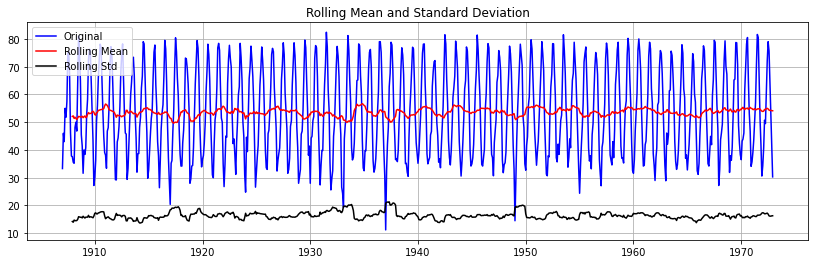

In [46]:
dftest(monthly_temp.temp)

Test Statistic         -7.878242e+00
p-value                 4.779473e-12
Lags Used               0.000000e+00
Observations Used       6.500000e+01
Critical Value (1%)    -3.535217e+00
Critical Value (5%)    -2.907154e+00
Critical Value (10%)   -2.591103e+00
dtype: float64


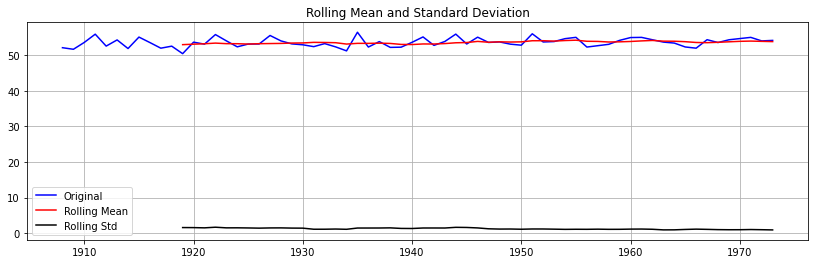

In [47]:
dftest(annual_temp)

Test Statistic          -0.449458
p-value                  0.901508
Lags Used               10.000000
Observations Used       55.000000
Critical Value (1%)     -3.555273
Critical Value (5%)     -2.915731
Critical Value (10%)    -2.595670
dtype: float64


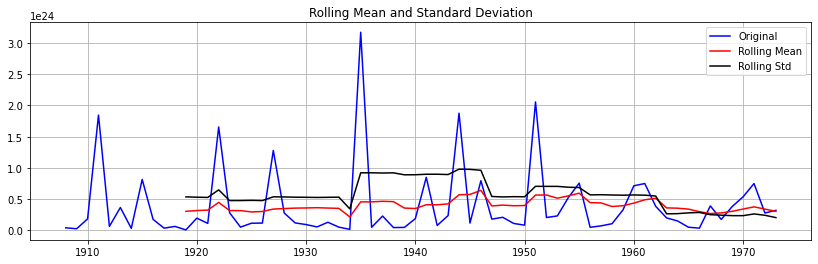

In [48]:
dftest(np.exp(annual_temp.temp))

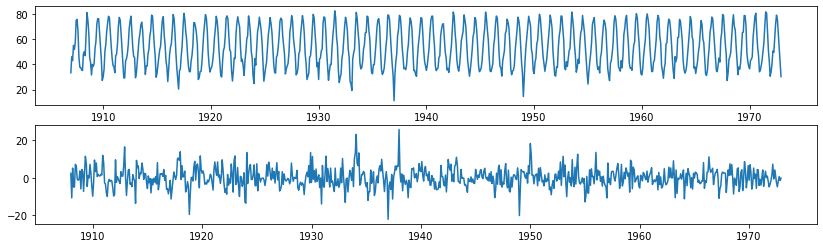

In [49]:
monthly_temp['lag_12']=monthly_temp.shift(12)
monthly_temp['seasonal_diff']=monthly_temp.temp-monthly_temp['lag_12']

fig,ax=plt.subplots(2,1)
ax[0].plot(monthly_temp.temp,label='original')
ax[1].plot(monthly_temp.seasonal_diff,label='seasonal diff')

SARIMA

In [50]:
def plots(data,lags=None):
    layout=(1,3)
    raw=plt.subplot2grid(layout,(0,0))
    acf=plt.subplot2grid(layout,(0,1))
    pacf=plt.subplot2grid(layout,(0,2))
    
    raw.plot(data)
    sn.tsa.graphics.plot_acf(data,lags=lags,ax=acf,zero=False)
    sn.tsa.graphics.plot_pacf(data,lags=lags,ax=pacf,zero=False)
    sns.despine()
    plt.tight_layout()

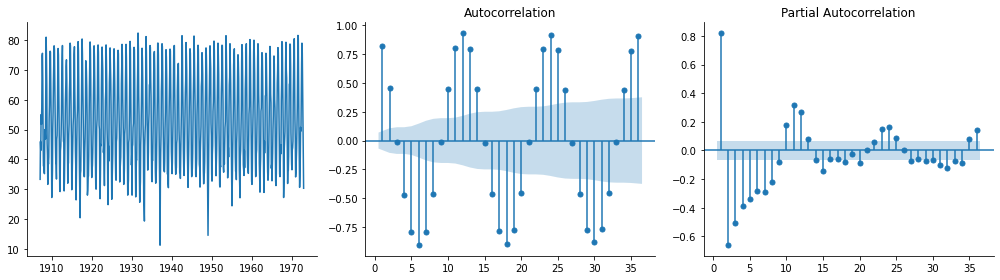

In [51]:
plots(monthly_temp.temp,lags=36)

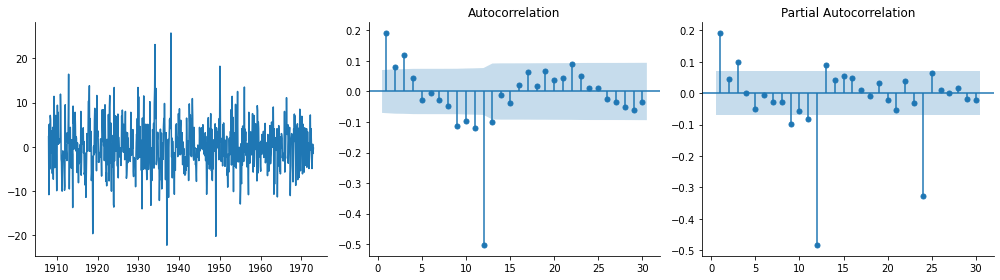

In [52]:
plots(monthly_temp.seasonal_diff.dropna(),lags=30)

In [53]:
sar=sn.tsa.statespace.SARIMAX(monthly_temp.temp,order=(1,0,0),seasonal_order=(0,1,1,12),
                             trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2128.873
Date:                              Wed, 18 May 2022   AIC                           4265.746
Time:                                      22:32:30   BIC                           4284.383
Sample:                                  01-01-1907   HQIC                          4272.914
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0127      0.007      1.698      0.090      -0.002       0.027
ar.L1          0.1791      0.035      5.105      0.000       0.110       0.248
ma.S.L12      -0.9995      1.133     -0.882      0.378      -3.220       1.221
sigma2        12.8929     14.489      0.890      0.374     -15.504      41.290
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               252.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.56
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

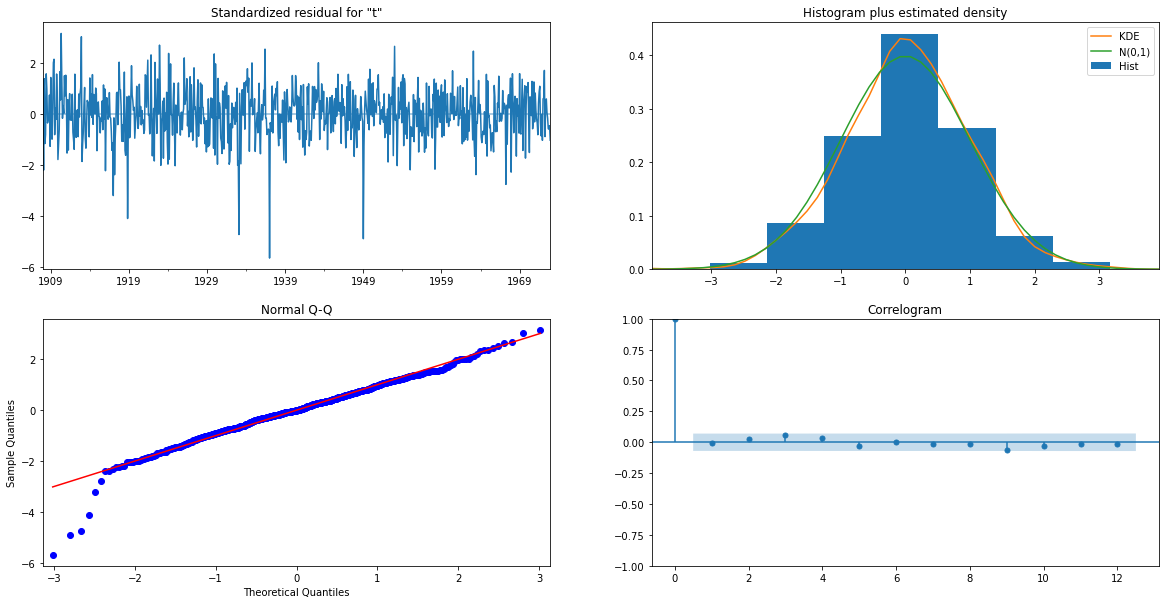

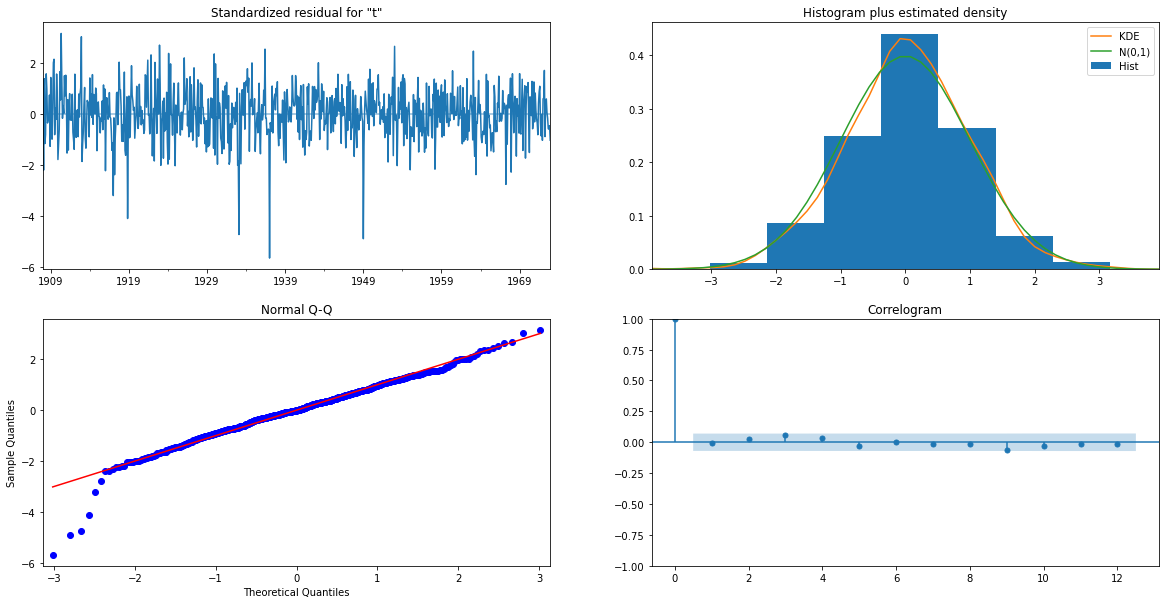

In [54]:
sar.plot_diagnostics(lags=12,figsize=(20,10))

<AxesSubplot:xlabel='month'>

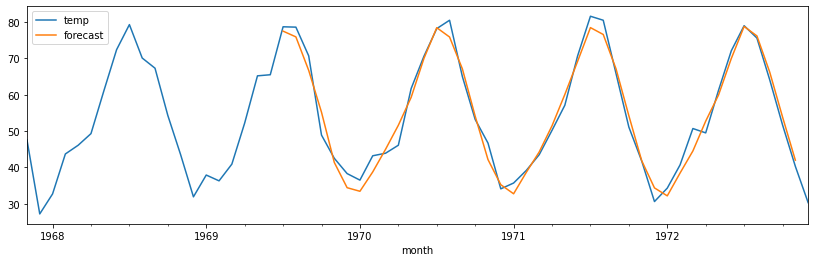

In [55]:
pd.plotting.register_matplotlib_converters()
monthly_temp['forecast']=sar.predict(start=750,end=790)
monthly_temp[730:][['temp','forecast']].plot()


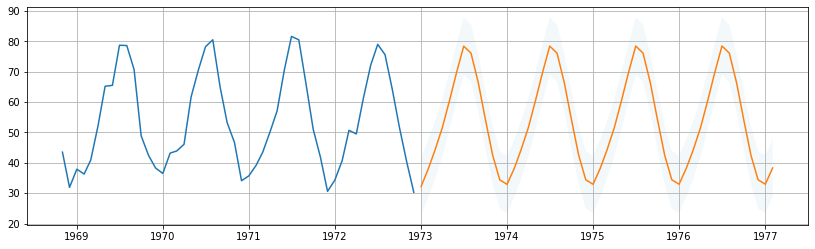

In [56]:
future_fcst=sar.get_forecast(50)
confidence_int=future_fcst.conf_int(alpha=0.01)
fcst=future_fcst.predicted_mean
plt.plot(monthly_temp.temp[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower temp'],confidence_int['upper temp'],alpha=0.05)
plt.grid()

In [60]:
#create and run statistical tests on model
norm_val,norm_p,skew,kurtosis=sar.test_normality('jarquebera')[0]
lb_val,lb_p=sar.test_serial_correlation(method='ljungbox')[0]
het_val,het_p=sar.test_heteroskedasticity('breakvar')[0]

lb_val=lb_val[-1]
lb_p=lb_p[-1]
durbin_watson=sn.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0,sar.loglikelihood_burn:])

print('Normality:val={:.3f},p={:.3f}'.format(norm_val,norm_p))
print('Ljung-Box: val={:.3f},p={:.3f}'.format(lb_val,lb_p))
print('Heteroskedasticity: val={:.3f},p={:.3f}'.format(het_val,het_p))
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality:val=252.768,p=0.000
Ljung-Box: val=15.499,p=0.905
Heteroskedasticity: val=0.708,p=0.006
Durbin-Watson: d=2.01


In [62]:
#from pyramid.arima import auto_arima
stepwise_model=pm.auto_arima(monthly_temp.temp,start_p=1,start_q=1,max_p=3,max_q=3,m=12,start_P=0,seasonal=True,d=0,D=1,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4796.839, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4546.179, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4794.867, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4769.737, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4451.142, Time=1.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4477.926, Time=1.29 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4452.084, Time=1.29 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4450.271, Time=1.69 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4545.537, Time=0.74 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=5.12 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=i

In [63]:
stepwise_model.seasonal_order

(2, 1, 0, 12)

In [64]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first=series.index.max()+relativedelta(months=1)
    pred_last=series.index.max()+relativedelta(months=num_months)
    date_range_index=pd.date_range(pred_first,pred_last,freq='MS')
    vals=model.predict(n_periods=num_months)
    return pd.DataFrame(vals,index=date_range_index)

In [65]:
preds=future_preds_df(stepwise_model,monthly_temp.temp,1000)


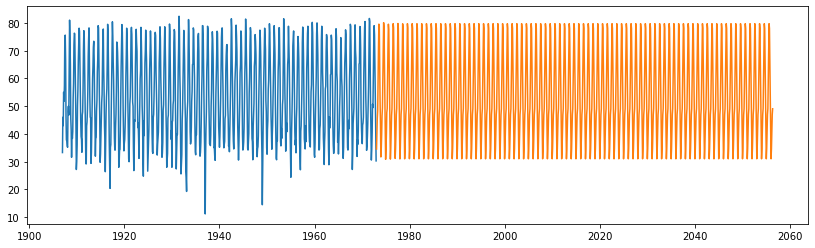

In [66]:
plt.plot(monthly_temp.temp)
plt.plot(preds)

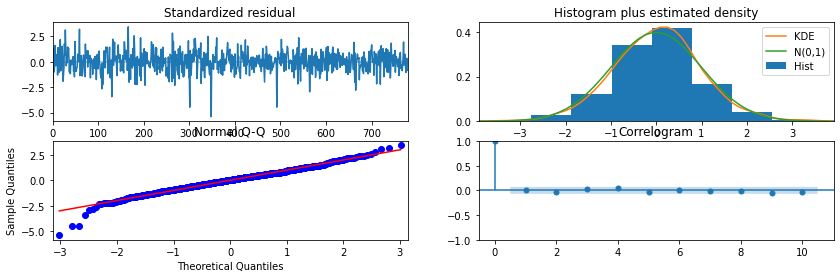

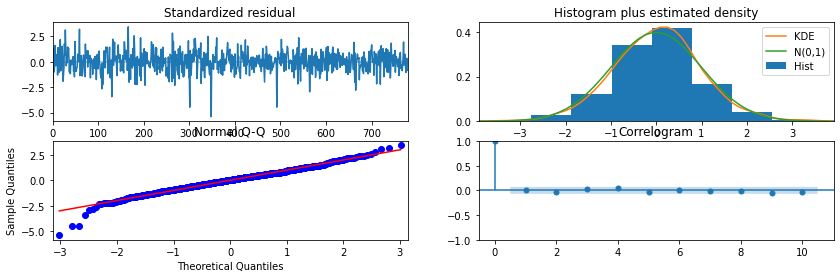

In [67]:
stepwise_model.plot_diagnostics()

In [68]:
print('auto-fit order:',stepwise_model.order)
print('auto-fir seasonal order:',stepwise_model.seasonal_order)

auto-fit order: (1, 0, 1)
auto-fir seasonal order: (2, 1, 0, 12)


In [73]:
def cross_validate(series,horizon,start,step_size,order=(1,0,0),seasonal_order=(0,0,0,0),trend=None):
    fcat=[]
    actual=[]
    date=[]
    for i in range(start,len(series)-horizon,step_size):
        model=sn.tsa.statespace.SARIMAX(series[:i+1],order=order,seasonal_order=seasonal_order,trend=trend).fit()
        fcst.append(model.forecast(steps=horizon)[-1])
        actual.append(series[i+horizon])
        date.append(series.index[i+horizon])
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)




In [74]:
warnings.filterwarnings('ignore')
series=monthly_temp.temp
horizon=12
start=700
step_size=1
order=(1,0,0)
seasonal_order=(0,1,1,12)

cv1=cross_validate(monthly_temp.temp,12,700,3,order=order,seasonal_order=seasonal_order)

TypeError: cannot concatenate object of type '<class 'numpy.float64'>'; only Series and DataFrame objs are valid